# **TÉCNICAS OPTIMIZACIÓN REDES CONVOLUCIONALES**


In [ ]:
#Librerías necesarias
from google.colab import drive 
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [ ]:
#Para acceder a los ficheros de drive
drive.mount('/content/gdrive')
#Listamos los ficheros existentes en el directorio raiz
!ls "/content/gdrive/MyDrive"

Mounted at /content/gdrive
'Colab Notebooks'   mask_data_aug_regu_opt.h5   primera_evaluacion
 DatosMercadoRuso   ModelosMercadoRuso
 dest_folder	    ModelosSOM


Carga de los datos de entrenamiento, validación y test.

In [ ]:
base_dir='/content/gdrive/MyDrive/dest_folder'
print(base_dir)
train_dir = os.path.join(base_dir, 'train')
print(train_dir)
val_dir = os.path.join(base_dir, 'val')
print(val_dir)
test_dir = os.path.join(base_dir, 'test')
print(test_dir)
# Entrenamiento
train_withmask_dir = os.path.join(train_dir, 'with_mask')
train_withoutmask_dir = os.path.join(train_dir, 'without_mask')
# Validacion
val_withmask_dir = os.path.join(val_dir, 'with_mask')
val_withoutmask_dir = os.path.join(val_dir, 'without_mask')
# Test
test_withmask_dir = os.path.join(test_dir, 'with_mask')
test_withoutmask_dir = os.path.join(test_dir, 'without_mask')

/content/gdrive/MyDrive/dest_folder
/content/gdrive/MyDrive/dest_folder/train
/content/gdrive/MyDrive/dest_folder/val
/content/gdrive/MyDrive/dest_folder/test


Se hace una rápida comprobación de que todo está cargado correctamente. Se han eliminado duplicados de los datos de test manualmente.

In [ ]:
print('Total de entrenamiento con máscara:', len(os.listdir(train_withmask_dir)))
print('Total de entrenamiento sin máscara:', len(os.listdir(train_withoutmask_dir)))
print('Total de validación con máscara:', len(os.listdir(val_withmask_dir)))
print('Total de validación sin máscara:', len(os.listdir(val_withoutmask_dir)))
print('Total de test con máscara:', len(os.listdir(test_withmask_dir)))
print('Total de test sin máscara:', len(os.listdir(test_withoutmask_dir)))

Total de entrenamiento con máscara: 658
Total de entrenamiento sin máscara: 657
Total de validación con máscara: 71
Total de validación sin máscara: 71
Total de test con máscara: 97
Total de test sin máscara: 97


## AUMENTO DE LA MUESTA Y REGULARIZACIÓN DROPOUT

La primera técnica de optimización consiste en aumentar la muestra mediante la aplicación de transformaciones sobre los datos de enrenamiento. En este caso, se aplican de manera aleatoria las siguientes transformaciones:

  - Traslaciones
  - Homotecias
  - Simetrías horizontales (las verticales no tienen sentido para imágenes de caras)


  

Antes de poder entrenar el modelo, es necesario convertir las imágenes en formato JPEG en tensores. Siguiendo a Chollet, los pasos a seguir son los siguiente:

  - Decodificar las imágenes en formato JPEG en un grid RGB
  - Convertir el grid anterior en tensores
  - Normalizar los datos mediante una homotecia que transforme el intervalo [0,255] al intervalo [0,1]
  
Todo esto se puede hacer de manera sencilla en tensorflow, con las siguientes instrucciones:


In [ ]:
# semilla para reproducir los resultados
seed=339
np.random.seed(seed)
tf.random.set_seed(seed)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   zoom_range=0.1,
                                   horizontal_flip=True
                                   )
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
alto, ancho = 150, 150
canal = 3

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(alto, ancho),
batch_size=batch_size,
class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
val_dir,
target_size=(alto, ancho),
batch_size=batch_size,
class_mode='binary')



test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(alto, ancho),
batch_size=batch_size,
class_mode='binary')

Found 1315 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


Recorremos los tensores para ver su estructura y que la carga ha ido correctamente:

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


 Red neuronal con los datos aumentados.

In [ ]:
# Estructura lineal
cnn_regu_dropout = tf.keras.Sequential()
# Primera capa de  convolución
cnn_regu_dropout.add(tf.keras.layers.Conv2D(16, 
                            (3,3), 
                            activation='relu', input_shape=(alto, ancho, canal)))
cnn_regu_dropout.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Segunda capa de  convolución
cnn_regu_dropout.add(tf.keras.layers.Conv2D(32, 
                            (3,3), 
                            activation='relu', input_shape=(alto, ancho, canal)))
cnn_regu_dropout.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_regu_dropout.add(tf.keras.layers.Dropout(0.25))

# Tercera capa de  convolución
cnn_regu_dropout.add(tf.keras.layers.Conv2D(64, 
                            (3,3), 
                            activation='relu', input_shape=(alto, ancho, canal)))
cnn_regu_dropout.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_regu_dropout.add(tf.keras.layers.Dropout(0.25))

# Cuarta capa de  convolución
cnn_regu_dropout.add(tf.keras.layers.Conv2D(128, 
                            (3,3), 
                            activation='relu', input_shape=(alto, ancho, canal)))
cnn_regu_dropout.add(tf.keras.layers.MaxPooling2D((2, 2)))


cnn_regu_dropout.add(tf.keras.layers.Flatten())
cnn_regu_dropout.add(layers.Dense(256, activation='relu'))
cnn_regu_dropout.add(tf.keras.layers.Dense(1, activation='sigmoid'))

Ésta es la estructura de la red neuronal, con cuatro capas de convolución-pooling y dos capas de dropout.

In [ ]:
cnn_regu_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)       

Usamos una métrica para un problema de clasificación de dos clases y el gradiente descendiente con momentum.

In [ ]:
cnn_regu_dropout.compile(loss='binary_crossentropy',
optimizer='rmsprop',
metrics=['accuracy'])

In [ ]:
Entrenamos el modelo con unas pocas épocas para evitar el sobreajuste.

In [ ]:
epocas = 10

steps_per_epoch = train_generator.n // batch_size 
validation_steps = validation_generator.n // batch_size

history = cnn_regu_dropout.fit(train_generator,
                               steps_per_epoch=steps_per_epoch,
                               epochs=epocas,
                               validation_data=validation_generator,
                               validation_steps=validation_steps)

Epoch 1/10
41/41 [==============================] - 255s 6s/step - loss: 0.6810 - accuracy: 0.6048 - val_loss: 0.5431 - val_accuracy: 0.8828
Epoch 2/10
41/41 [==============================] - 13s 319ms/step - loss: 0.5625 - accuracy: 0.7537 - val_loss: 0.4844 - val_accuracy: 0.9375
Epoch 3/10
41/41 [==============================] - 13s 321ms/step - loss: 0.3942 - accuracy: 0.8605 - val_loss: 0.1319 - val_accuracy: 0.9766
Epoch 4/10
41/41 [==============================] - 13s 314ms/step - loss: 0.3478 - accuracy: 0.8659 - val_loss: 0.1257 - val_accuracy: 0.9688
Epoch 5/10
41/41 [==============================] - 13s 320ms/step - loss: 0.2938 - accuracy: 0.8995 - val_loss: 0.1608 - val_accuracy: 0.9531
Epoch 6/10
41/41 [==============================] - 13s 319ms/step - loss: 0.2507 - accuracy: 0.9127 - val_loss: 0.4108 - val_accuracy: 0.8828
Epoch 7/10
41/41 [==============================] - 13s 321ms/step - loss: 0.2460 - accuracy: 0.9275 - val_loss: 0.0314 - val_accuracy: 0.9922
E

Investigamos si existe sobreajuste mediante un análisis gráfico.

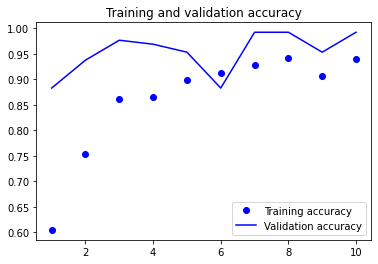

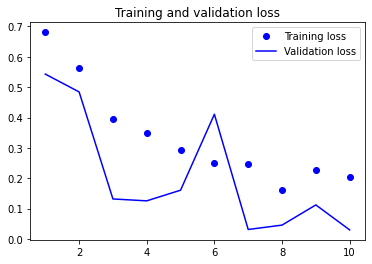

In [ ]:
# construcción de un data.frame
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

No parece haber sobreajuste con tan pocas épocas, al tiempo que se consigue un buen ajuste. Comprobamos esta última afirmación probando sobre los datos de test.

In [ ]:
#cnn_regu_dropout.save('/content/gdrive/MyDrive/ModelosConvolucional/cnn_regu_dropout')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ModelosConvolucional/cnn_regu_dropout/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ModelosConvolucional/cnn_regu_dropout/assets


In [ ]:
#new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ModelosConvolucional/cnn_regu_dropout')

[]

Matriz de confusión sobre los datos de validación.

5/5 [==============================] - 1s 100ms/step - loss: 0.0283 - accuracy: 0.9930
Evaluación accuracy: 99.30%


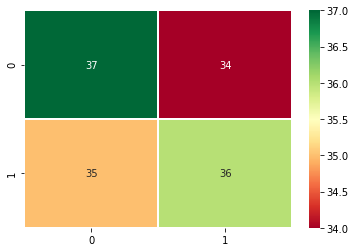

In [ ]:
validation_generator.reset()

# Evaluación del modelo en la muestra de Validation -> muestra total
scores = cnn_regu_dropout.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("Evaluación ", cnn_regu_dropout.metrics_names[1], scores[1]*100))

# model_tf_hub.metrics_names  -> [0]: loss [1]: accuracy

# predicciones de las instancias
predictions_proba = cnn_regu_dropout.predict(validation_generator)
predictions_class = np.where(predictions_proba > 0.5, 1, 0)

# matriz de confusión
sns.heatmap(confusion_matrix(validation_generator.labels, predictions_class), cmap="RdYlGn", linewidths=.5, 
            annot = True,  fmt='.0f', cbar=True)

plt.show()

Matriz de confusión sobre los datos de test.

7/7 [==============================] - 40s 7s/step - loss: 0.0628 - accuracy: 0.9794
Evaluación accuracy: 97.94%


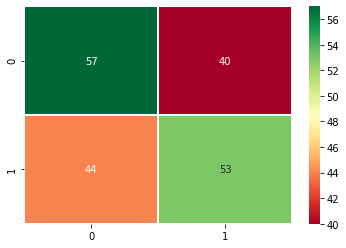

In [ ]:


# Evaluación del modelo en la muestra de Validation -> muestra total
scores = cnn_regu_dropout.evaluate(test_generator)
scores
print("%s%s: %.2f%%" % ("Evaluación ", cnn_regu_dropout.metrics_names[1], scores[1]*100))

# model_tf_hub.metrics_names  -> [0]: loss [1]: accuracy

# predicciones de las instancias
predictions_proba = cnn_regu_dropout.predict(test_generator)
predictions_class = np.where(predictions_proba >0.5, 1, 0)

#matriz de confusión
sns.heatmap(confusion_matrix(test_generator.labels, predictions_class), cmap="RdYlGn", linewidths=.5, 
             annot = True,  fmt='.0f', cbar=True)

plt.show()

Puesto que se consigue una precisión acorde a los datos de validación, descartamos el sobreajuste en el entrenamiento del modelo.

# Optimización usando algoritmos preentrenados

La idea de este algoritmo es usar los patrones aprendidos por otras redes convolucionales ya entrenadas y usar ese conocimiento para nuestro problema específico. Para ello, a la base convolucional del modelo ya entrenado, se añade una campa densa adaptada a nuestro problema de clasificación concreto.

Usaremos la red Xception.

Cargamos la red Xception de la librería keras.

In [ ]:
Xception = tf.keras.applications.Xception(include_top=False, input_shape=(alto, ancho, canal), weights='imagenet')

83689472/83683744 [==============================] - 1s 0us/step


Configuramos una nueva red para que su base no sea entrenable y añadimos una red densa sobre la base de Xception adaptada a nuestro problema de clasificación.

In [ ]:
Xception.trainable = False

cnn_Xception_ft = tf.keras.Sequential()
cnn_Xception_ft.add(Xception)
cnn_Xception_ft.add(tf.keras.layers.Flatten())
cnn_Xception_ft.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_Xception_ft.add(tf.keras.layers.Dropout(0.20))
cnn_Xception_ft.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
cnn_Xception_ft.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3276864   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 24,138,409
Trainable params: 3,276,929
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
cnn_Xception_ft.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=2e-5),
metrics=['accuracy'])

Entrenamos el modelo con unas pocas épocas con la esperanza de no sobreentrenar el modelo.

In [ ]:
validation_generator.reset()

epocas = 8

steps_per_epoch = train_generator.n // batch_size 
validation_steps = validation_generator.n // batch_size

history = cnn_Xception_ft.fit(train_generator,
                               steps_per_epoch=steps_per_epoch,
                               epochs=epocas,
                               validation_data=validation_generator,
                               validation_steps=validation_steps)

Epoch 1/8
41/41 [==============================] - 14s 349ms/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 4.4968e-04 - val_accuracy: 1.0000
Epoch 2/8
41/41 [==============================] - 14s 344ms/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 1.3530e-04 - val_accuracy: 1.0000
Epoch 3/8
41/41 [==============================] - 14s 340ms/step - loss: 0.0125 - accuracy: 0.9953 - val_loss: 6.0309e-04 - val_accuracy: 1.0000
Epoch 4/8
41/41 [==============================] - 14s 339ms/step - loss: 0.0185 - accuracy: 0.9922 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 5/8
41/41 [==============================] - 14s 341ms/step - loss: 0.0281 - accuracy: 0.9930 - val_loss: 3.6554e-04 - val_accuracy: 1.0000
Epoch 6/8
41/41 [==============================] - 14s 347ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 5.0308e-04 - val_accuracy: 1.0000
Epoch 7/8
41/41 [==============================] - 14s 351ms/step - loss: 0.0190 - accuracy: 0.9924 - val_loss: 4.2564e-04 - val

In [ ]:
#cnn_Xception_ft.save('/content/gdrive/MyDrive/ModelosConvolucional/cnn_Xception_ft') 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ModelosConvolucional/cnn_Xception_ft/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ModelosConvolucional/cnn_Xception_ft/assets


Plot para ver la diferencia gráfica entre los datos de validación y entrenamiento,

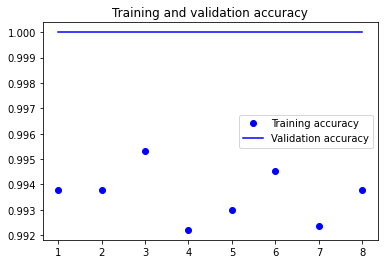

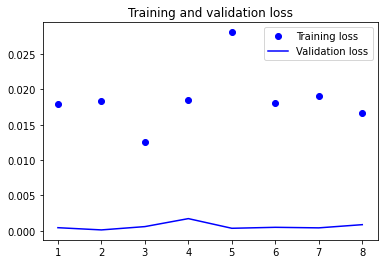

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Matriz de confusión para los datos de validación.

5/5 [==============================] - 1s 116ms/step - loss: 0.0014 - accuracy: 1.0000
Evaluación accuracy: 100.00%


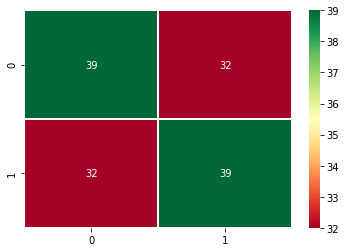

In [ ]:
validation_generator.reset()

# Evaluación del modelo en la muestra de Validation -> muestra total
scores = cnn_Xception_ft.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("Evaluación ", cnn_Xception_ft.metrics_names[1], scores[1]*100))

# model_tf_hub.metrics_names  -> [0]: loss [1]: accuracy

# predicciones de las instancias
predictions_proba = cnn_Xception_ft.predict(validation_generator)
predictions_class = np.where(predictions_proba > 0.5, 1, 0)

# matriz de confusión
sns.heatmap(confusion_matrix(validation_generator.labels, predictions_class), cmap="RdYlGn", linewidths=.5, 
            annot = True,  fmt='.0f', cbar=True)

plt.show()

Matriz de confusión para los datos de test.

7/7 [==============================] - 1s 117ms/step - loss: 0.0270 - accuracy: 0.9897
Evaluación accuracy: 98.97%


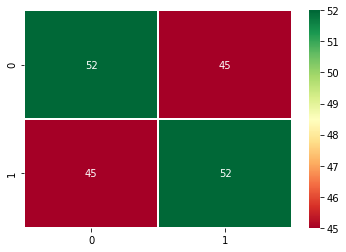

In [ ]:
# Evaluación del modelo en la muestra de Validation -> muestra total
scores = cnn_Xception_ft.evaluate(test_generator)
print("%s%s: %.2f%%" % ("Evaluación ", cnn_Xception_ft.metrics_names[1], scores[1]*100))

# model_tf_hub.metrics_names  -> [0]: loss [1]: accuracy

# predicciones de las instancias
predictions_proba = cnn_Xception_ft.predict(test_generator)
predictions_class = np.where(predictions_proba >0.5, 1, 0)

#matriz de confusión
sns.heatmap(confusion_matrix(test_generator.labels, predictions_class), cmap="RdYlGn", linewidths=.5, 
             annot = True,  fmt='.0f', cbar=True)

plt.show()

La red muestra una precisión muy próxima a los datos de validación

## FINE TUNING

La ultima técnica que se va a probar es la de fine tunning, la cual consiste en congelar toda la base convolucional de una red ya entrenada, exceptuando las últimas capas. La idea es, como en la redes preentrenadas, aprovechar los patrones ya aprendidos por la red y entrenar sólo las capas que captan los patrones más específicos que son, como sabemos, las últimas capas de una red convolucional.

De nuevo, usaremos la red XCeption, la cual tiene una estructura un poco diferente a las redes convolucionales estudiadas en el curso. 

In [ ]:
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Configuramos la base convolucional para que sólo la última capa sea entrenable.

In [ ]:
Xception.trainable = True

set_trainable=False
for layer in Xception.layers:
    if layer.name =='block14_sepconv2':
      set_trainable=True
    if set_trainable:
      layer.trainable=True
    else:
      layer.trainable=False

In [ ]:

cnn_Xception_1 = tf.keras.Sequential()
cnn_Xception_1.add(Xception)
cnn_Xception_1.add(tf.keras.layers.Dropout(0.20))
cnn_Xception_1.add(tf.keras.layers.Flatten())
cnn_Xception_1.add(tf.keras.layers.Dense(16, activation='relu'))
cnn_Xception_1.add(tf.keras.layers.Dropout(0.20))
cnn_Xception_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_Xception_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                819216    
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 21,680,713
Trainable params: 819,233
Non-trainable params: 20,861,480
____________________________________

In [ ]:
cnn_Xception_1.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=2e-5),
metrics=['accuracy'])

Entrenamiento del modelo.

In [ ]:
epocas = 10

steps_per_epoch = train_generator.n // batch_size 
validation_steps = validation_generator.n // batch_size

history = cnn_Xception_1.fit(train_generator,
                               steps_per_epoch=steps_per_epoch,
                               epochs=epocas,
                               validation_data=validation_generator,
                               validation_steps=validation_steps)

Epoch 1/10
41/41 [==============================] - 18s 374ms/step - loss: 0.3061 - accuracy: 0.8854 - val_loss: 0.0649 - val_accuracy: 0.9922
Epoch 2/10
41/41 [==============================] - 15s 355ms/step - loss: 0.1425 - accuracy: 0.9571 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 3/10
41/41 [==============================] - 15s 351ms/step - loss: 0.1096 - accuracy: 0.9587 - val_loss: 0.0201 - val_accuracy: 1.0000
Epoch 4/10
41/41 [==============================] - 14s 351ms/step - loss: 0.0916 - accuracy: 0.9688 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 5/10
41/41 [==============================] - 14s 346ms/step - loss: 0.0802 - accuracy: 0.9743 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 6/10
41/41 [==============================] - 14s 353ms/step - loss: 0.0736 - accuracy: 0.9758 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 7/10
41/41 [==============================] - 15s 355ms/step - loss: 0.0762 - accuracy: 0.9727 - val_loss: 0.0072 - val_accuracy: 1.0000

In [ ]:
#cnn_Xception_1.save('/content/gdrive/MyDrive/ModelosConvolucional/cnn_Xception_1')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ModelosConvolucional/cnn_Xception_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ModelosConvolucional/cnn_Xception_1/assets


Precisión en los datos de entrenamiento frente a los de validación.

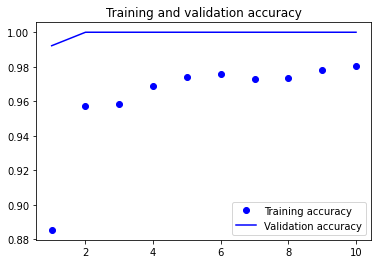

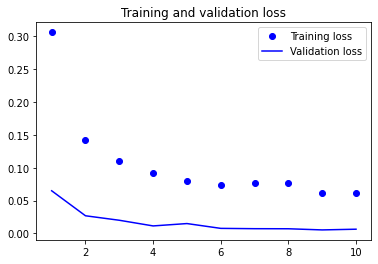

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

5/5 [==============================] - 1s 125ms/step - loss: 0.0062 - accuracy: 1.0000
Evaluación accuracy: 100.00%


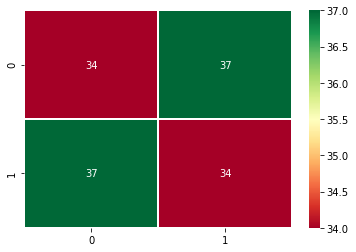

In [ ]:
validation_generator.reset()

# Evaluación del modelo en la muestra de Validation -> muestra total
scores = cnn_Xception_1.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("Evaluación ", cnn_Xception_1.metrics_names[1], scores[1]*100))

# model_tf_hub.metrics_names  -> [0]: loss [1]: accuracy

# predicciones de las instancias
predictions_proba = cnn_Xception_1.predict(validation_generator)
predictions_class = np.where(predictions_proba > 0.5, 1, 0)

# matriz de confusión
sns.heatmap(confusion_matrix(validation_generator.labels, predictions_class), cmap="RdYlGn", linewidths=.5, 
            annot = True,  fmt='.0f', cbar=True)

plt.show()

7/7 [==============================] - 1s 120ms/step - loss: 0.0408 - accuracy: 0.9897
Evaluación accuracy: 98.97%


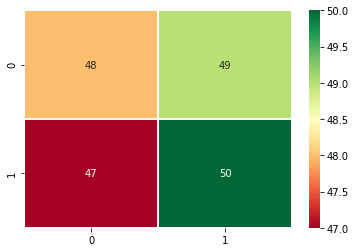

In [ ]:
# Evaluación del modelo en la muestra de Validation -> muestra total

test_generator.reset()

scores = cnn_Xception_1.evaluate(test_generator)
scores
print("%s%s: %.2f%%" % ("Evaluación ", cnn_Xception_1.metrics_names[1], scores[1]*100))

# model_tf_hub.metrics_names  -> [0]: loss [1]: accuracy

# predicciones de las instancias
predictions_proba = cnn_Xception_1.predict(test_generator)
predictions_class = np.where(predictions_proba >0.5, 1, 0)

#matriz de confusión
sns.heatmap(confusion_matrix(test_generator.labels, predictions_class), cmap="RdYlGn", linewidths=.5, 
             annot = True,  fmt='.0f', cbar=True)

plt.show()

In [ ]:
!jupyter nbconvert --to html RedesConvolucionales.ipynb

[NbConvertApp] Converting notebook RedesConvolucionales.ipynb to html
[NbConvertApp] Writing 536943 bytes to RedesConvolucionales.html


Obteniéndose un resultado similar a la técnica de redes entrenadas.

In [ ]:
!pip install nbconvert